In [1]:
# Simple Convolutional Autoencoder
# Code by GunhoChoi

import torch
import torch.nn as nn
import torch.utils as utils
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Set Hyperparameters

epoch = 100
batch_size =100
learning_rate = 0.001

# Download Data

mnist_train = dset.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test  = dset.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

# Set Data Loader(input pipeline)

train_loader = torch.utils.data.DataLoader(dataset=mnist_train,batch_size=batch_size,shuffle=True)

Files already downloaded
Files already downloaded


In [3]:
# Encoder 
# torch.nn.Conv2d(in_channels, out_channels, kernel_size,
#                 stride=1, padding=0, dilation=1,
#                 groups=1, bias=True)
# batch x 1 x 28 x 28 -> batch x 512

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1,16,3,padding=1),   # batch x 16 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Conv2d(16,32,3,padding=1),  # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,64,3,padding=1),  # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.MaxPool2d(2,2)   # batch x 64 x 14 x 14
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64,128,3,padding=1),  # batch x 64 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.MaxPool2d(2,2),
                        nn.Conv2d(128,256,3,padding=1),  # batch x 64 x 7 x 7
                        nn.ReLU()
        )
        
                
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(batch_size, -1)
        return out
    
encoder = Encoder().cuda()

In [4]:
# Decoder 
# torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size,
#                          stride=1, padding=0, output_padding=0,
#                          groups=1, bias=True)
# output_height = (height-1)*stride + kernel_size - 2*padding + output_padding
# batch x 512 -> batch x 1 x 28 x 28

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.ConvTranspose2d(256,128,3,2,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,64,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64)
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(64,16,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.ConvTranspose2d(16,1,3,2,1,1),
                        nn.ReLU()
        )
        
    def forward(self,x):
        out = x.view(batch_size,256,7,7)
        out = self.layer1(out)
        out = self.layer2(out)
        return out

decoder = Decoder().cuda()

In [5]:
# Check output of autoencoder

for image,label in train_loader:
    image = Variable(image).cuda()
    
    output = encoder(image)
    output = decoder(output)
    print(output)
    break

Variable containing:
( 0 , 0 ,.,.) = 
  0.0000  0.0000  0.0000  ...   0.0406  0.0000  0.0000
  0.0000  0.1839  0.0000  ...   0.1407  0.0000  0.0000
  0.0000  0.1896  0.0178  ...   0.0000  0.0000  0.0067
           ...             ⋱             ...          
  0.0000  0.0288  0.0262  ...   0.1438  0.0061  0.0000
  0.0000  0.0771  0.0000  ...   0.0996  0.0000  0.0000
  0.0000  0.0690  0.0000  ...   0.2391  0.0000  0.0361
      ⋮  

( 1 , 0 ,.,.) = 
  0.0000  0.0000  0.0587  ...   0.0299  0.0001  0.0000
  0.0000  0.0915  0.0000  ...   0.2374  0.0000  0.0000
  0.0000  0.0000  0.0155  ...   0.0459  0.0000  0.0460
           ...             ⋱             ...          
  0.0000  0.0000  0.0912  ...   0.2973  0.0000  0.0320
  0.0000  0.0274  0.0361  ...   0.0904  0.0000  0.0016
  0.0000  0.0707  0.0642  ...   0.2412  0.0000  0.0589
      ⋮  

( 2 , 0 ,.,.) = 
  0.0000  0.0000  0.0928  ...   0.0000  0.0089  0.0000
  0.0000  0.0087  0.0000  ...   0.1656  0.0240  0.0000
  0.0000  0.0114  0.0000  

In [6]:
# loss func and optimizer
# we compute reconstruction after decoder so use Mean Squared Error
# In order to use multi parameters with one optimizer,
# concat parameters after changing into list

parameters = list(encoder.parameters())+ list(decoder.parameters())
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

In [7]:
# train encoder and decoder
# save and load model

try:
	encoder, decoder = torch.load('./model/autoencoder.pkl')
	print("\n--------model restored--------\n")
except:
	pass

for i in range(epoch):
    for image,label in train_loader:
        image = Variable(image).cuda()
        #label = Variable(label.float()).cuda()
        optimizer.zero_grad()
        output = encoder(image)
        output = decoder(output)
        loss = loss_func(output,image)
        loss.backward()
        optimizer.step()
        
    if i % 2 == 0:
        torch.save([encoder,decoder],'./model/autoencoder.pkl')
        print(loss)

/usr/local/lib/python3.5/dist-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.5/dist-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type Decoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Variable containing:
1.00000e-03 *
  1.3999
[torch.cuda.FloatTensor of size 1 (GPU 0)]



Input Image


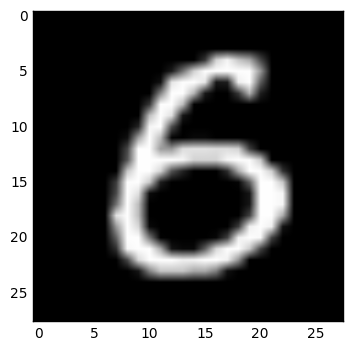

Output Image


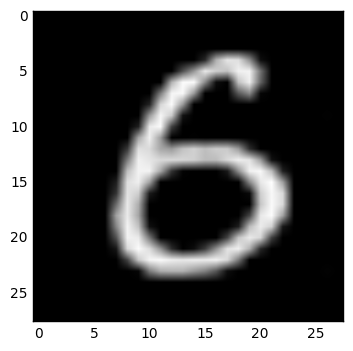

In [8]:
input_img = image[0].cpu()
output_img = output[0].cpu()

inp = input_img.data.numpy()
out = output_img.data.numpy()

print("Input Image")
plt.imshow(inp[0],cmap='gray')
plt.show()

print("Output Image")
plt.imshow(out[0],cmap="gray")
plt.show()